In [1]:
import pandas as pd
import numpy as np
import json

import augmentation, torch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random

In [2]:
train_json_path = "/opt/ml/detection/dataset/train.json"
test_json_path = "/opt/ml/detection/dataset/test.json"

with open(train_json_path, 'r') as contents :
    train_data = json.load(contents)
    
with open(test_json_path, 'r') as contents :
    test_data = json.load(contents)    

Categori 별

categories ['General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']
count {'General trash': 3967, 'Metal': 937, 'Plastic bag': 5179, 'Glass': 983, 'Plastic': 2944, 'Paper pack': 898, 'Styrofoam': 1264, 'Paper': 6353, 'Clothing': 469, 'Battery': 160}, total:23154


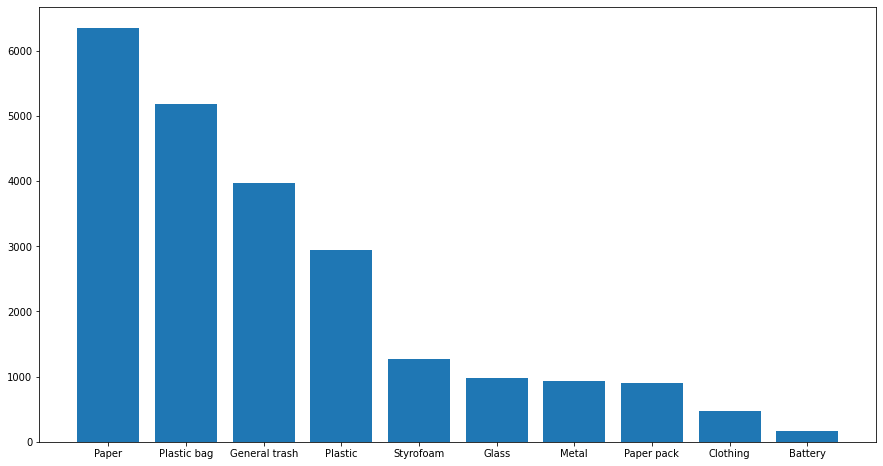

In [3]:
categories = []
for x in train_data["categories"]:
    categories.append(x["name"])
print(f"categories {categories}")

count = {}
for x in train_data["annotations"]:
    count[categories[x["category_id"]]] = count.get(categories[x["category_id"]], 1) + 1
print(f"count {count}, total:{sum(count.values())}")
count = dict(sorted(count.items(), key = lambda x :x[1], reverse=True))

plt.figure(figsize=(15,8))
plt.bar(count.keys(), count.values())
plt.show()

In [4]:
df_train = pd.json_normalize(train_data['annotations'])
# df_train.astype({"area":np.int64})
# print(df_train["area"])

In [5]:
pd.options.display.float_format = '{:.3f}'.format
df_train.describe().astype(np.float64) 

image_id  category_id        area   iscrowd        id
count 23144.000    23144.000   23144.000 23144.000 23144.000
mean   2439.377        3.409   92863.958     0.000 11571.500
std    1410.659        2.834  135979.148     0.000  6681.242
min       0.000        0.000       0.560     0.000     0.000
25%    1206.000        1.000    9997.670     0.000  5785.750
50%    2453.500        3.000   38938.470     0.000 11571.500
75%    3678.000        7.000  119122.475     0.000 17357.250
max    4882.000        9.000 1048371.210     0.000 23143.000

### 가장 작은 크기를 가지는 것은 0.56까지 있다. 

In [6]:
print(df_train[df_train['area'] < 300])

# print(df_train[df_train["image_id"] == 1063].count())

       image_id  category_id    area                       bbox  iscrowd  \
5067       1056            5 105.080   [530.6, 70.9, 14.2, 7.4]        0   
5159       1063            0   0.560   [647.8, 460.2, 0.7, 0.8]        0   
6539       1377            1   3.120   [719.8, 604.7, 1.3, 2.4]        0   
7227       1521            3 275.120  [728.4, 307.8, 36.2, 7.6]        0   
17594      3712            2  66.250  [883.8, 638.5, 12.5, 5.3]        0   

          id  
5067    5067  
5159    5159  
6539    6539  
7227    7227  
17594  17594  


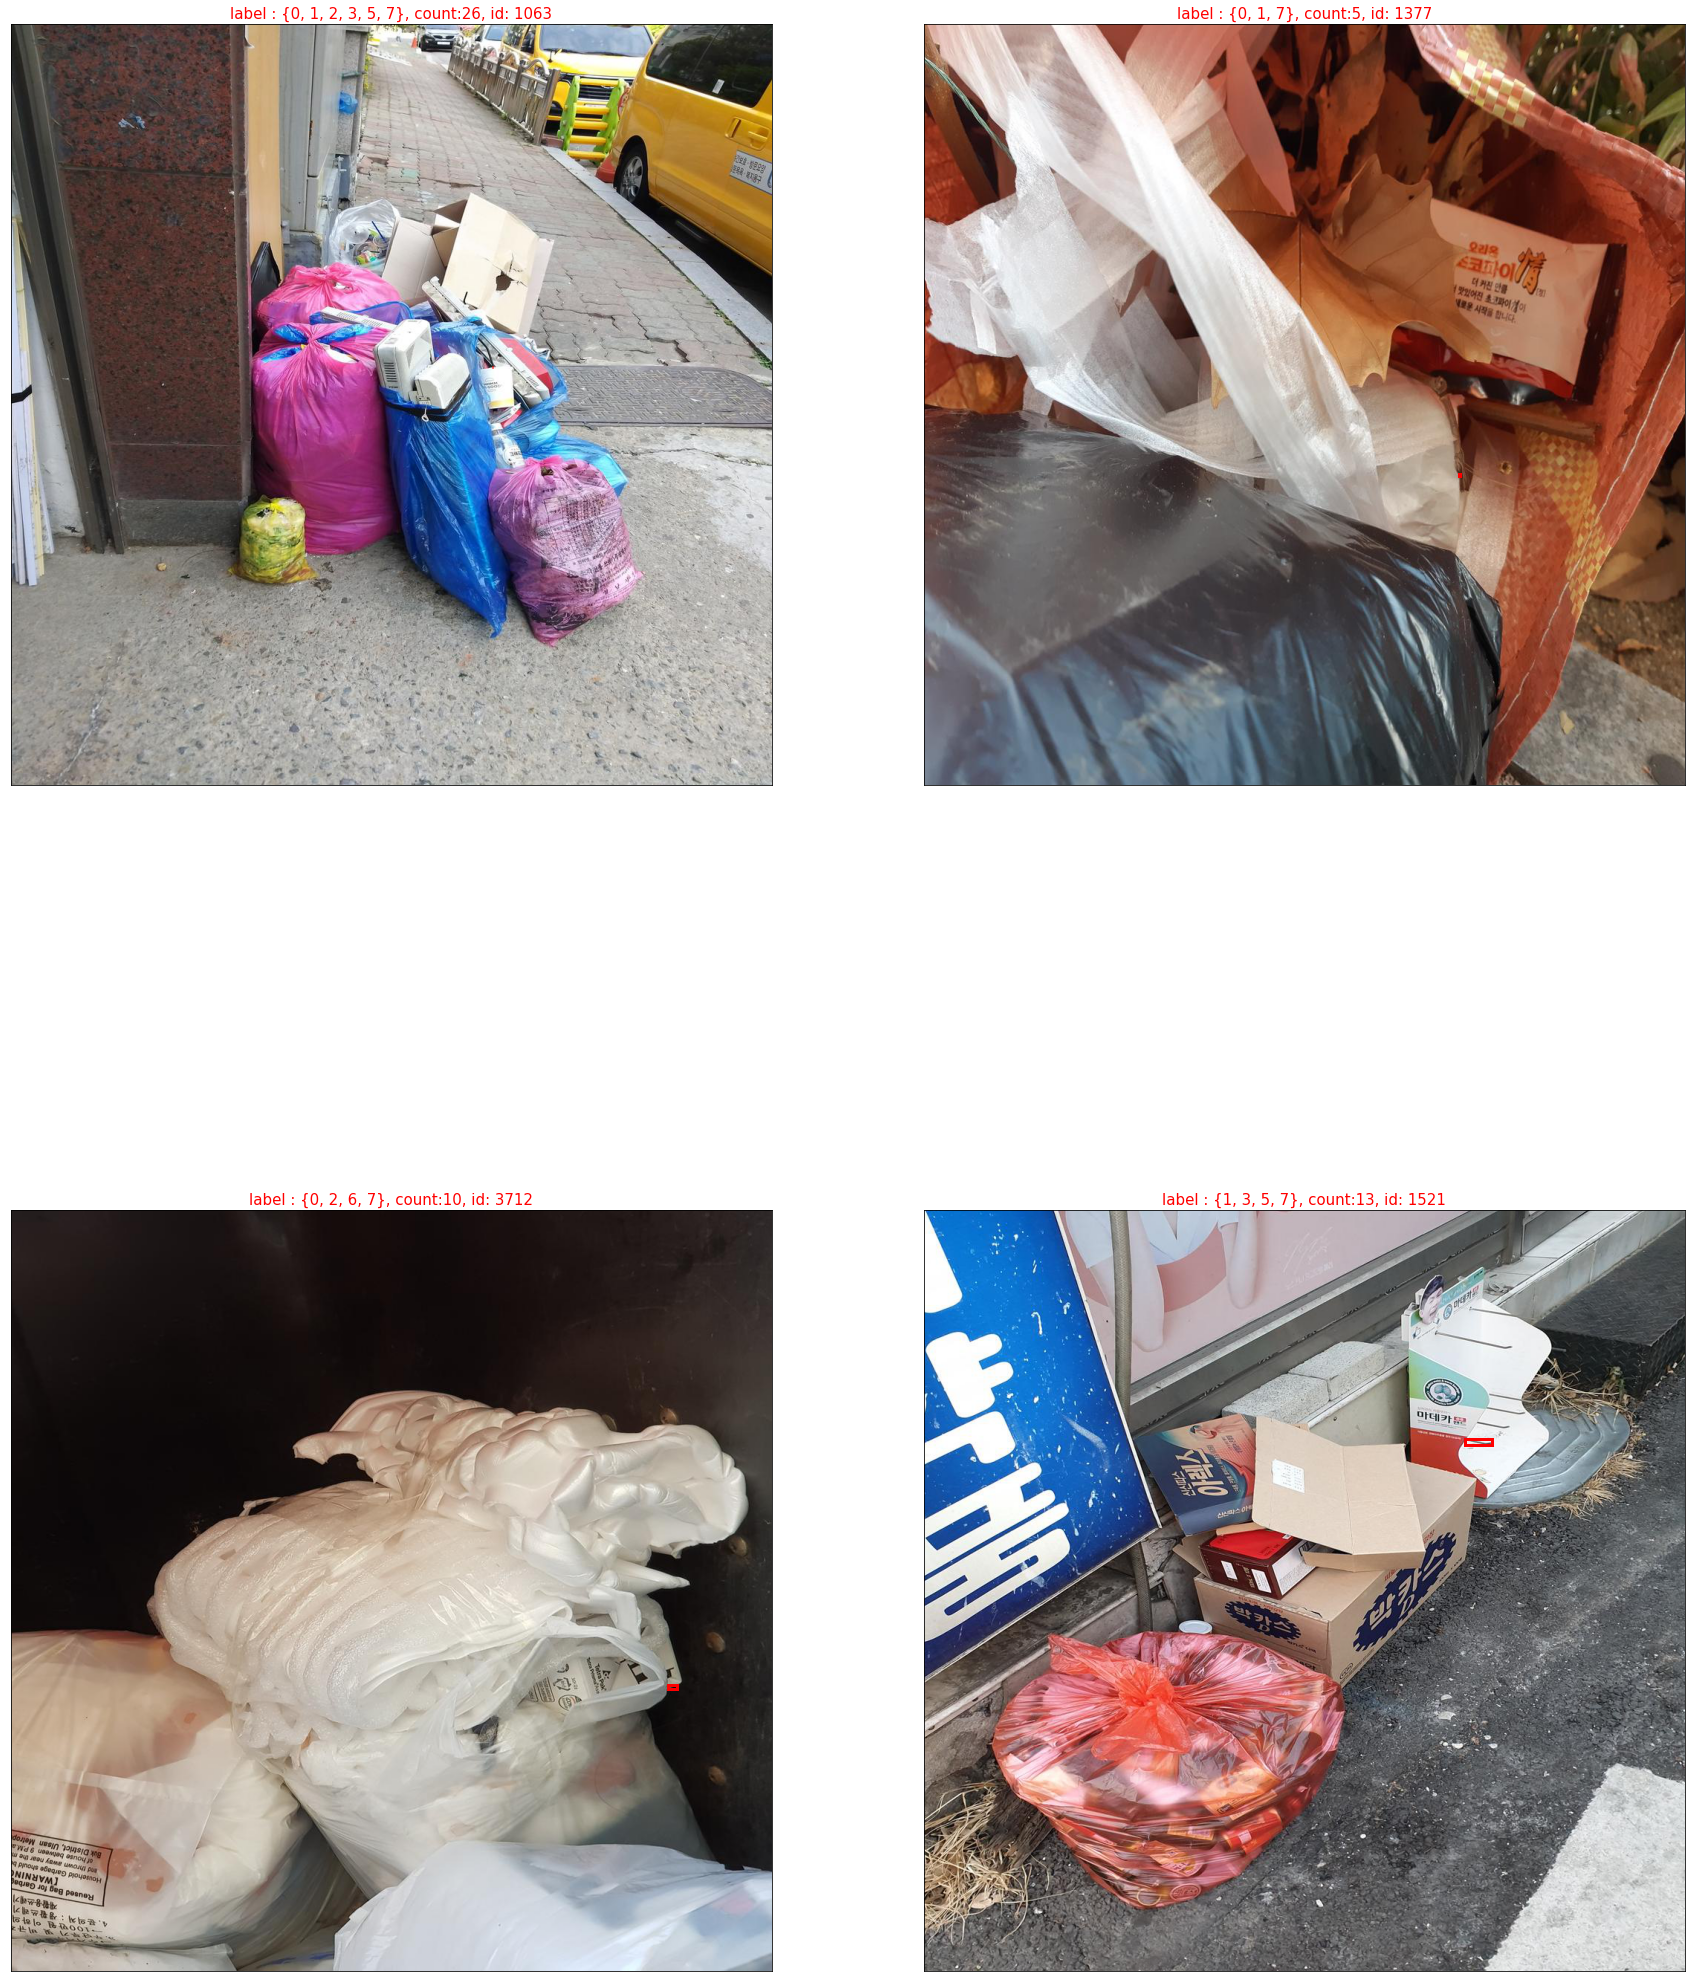

In [21]:
plt.figure(figsize=(30, 40))
plt.rcParams['axes.titlesize'] = 15
plt.axis('off')

for i, x in enumerate([1063, 1377, 3712,1521]):
    plt.subplot(2, 2,i+1)
    image, bboxs, label = dataset[x]
    img = plt.imshow(image); img.axes.get_xaxis().set_visible(False); img.axes.get_yaxis().set_visible(False)
    plt.gca().set_title(f"label : {set(label.tolist())}, count:{len(bboxs)}, id: {x}", color='r')
    if bboxs == None: pass
    else:
        for t, bbox in enumerate(bboxs):
            min_x, min_y, max_x, max_y = bbox
            if min_x == 647.8 or min_x == 719.8 or min_x == 883.8 or min_x == 728.4:    
                plt.gca().add_patch(Rectangle((min_x, min_y), max_x-min_x, max_y-min_y, edgecolor="r", facecolor='none', linewidth=3))
            

# 그림을 보자import matplotlib.pyplot as plt

In [ ]:
!pip install augmentation

### COCO_detection ()

In [12]:
import os, torch, torchvision
from PIL import Image
from pycocotools.coco import COCO
from torch.utils.data import Dataset


class COCO_detection(Dataset):
    def __init__(self, img_dir, ann, transforms=None):
        super(COCO_detection, self).__init__()
        self.img_dir = img_dir
        self.transforms = transforms
        self.coco = COCO(ann)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.label_map = {raw_label:i for i, raw_label in enumerate(self.coco.getCatIds())}

    def _load_image(self, id_):
        img = self.coco.loadImgs(id_)[0]['file_name']
        return Image.open(os.path.join(self.img_dir, img)).convert('RGB')

    def _load_target(self, id_):
        if len(self.coco.loadAnns(self.coco.getAnnIds(id_))) == 0: return None, None
        bboxs, labels = [], []
        for ann in self.coco.loadAnns(self.coco.getAnnIds(id_)):
            min_x, min_y, w, h = ann['bbox']
            bboxs.append(torch.FloatTensor([min_x, min_y, min_x+w, min_y+h]))
            labels.append(self.label_map[ann['category_id']])
        bboxs, labels = torch.stack(bboxs, 0), torch.LongTensor(labels)
        return bboxs, labels

    def __getitem__(self, index):
        id_ = self.ids[index]
        image, (bboxs, labels) = self._load_image(id_), self._load_target(id_)
        if self.transforms is not None:
            image, bboxs = self.transforms(image, bboxs)

        return image, bboxs, labels

    def __len__(self):
        return len(self.ids)
    

In [13]:
import augmentation, torch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random

In [14]:
train_data_path = "/opt/ml/detection/dataset/"

dataset = COCO_detection(train_data_path, train_json_path)

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


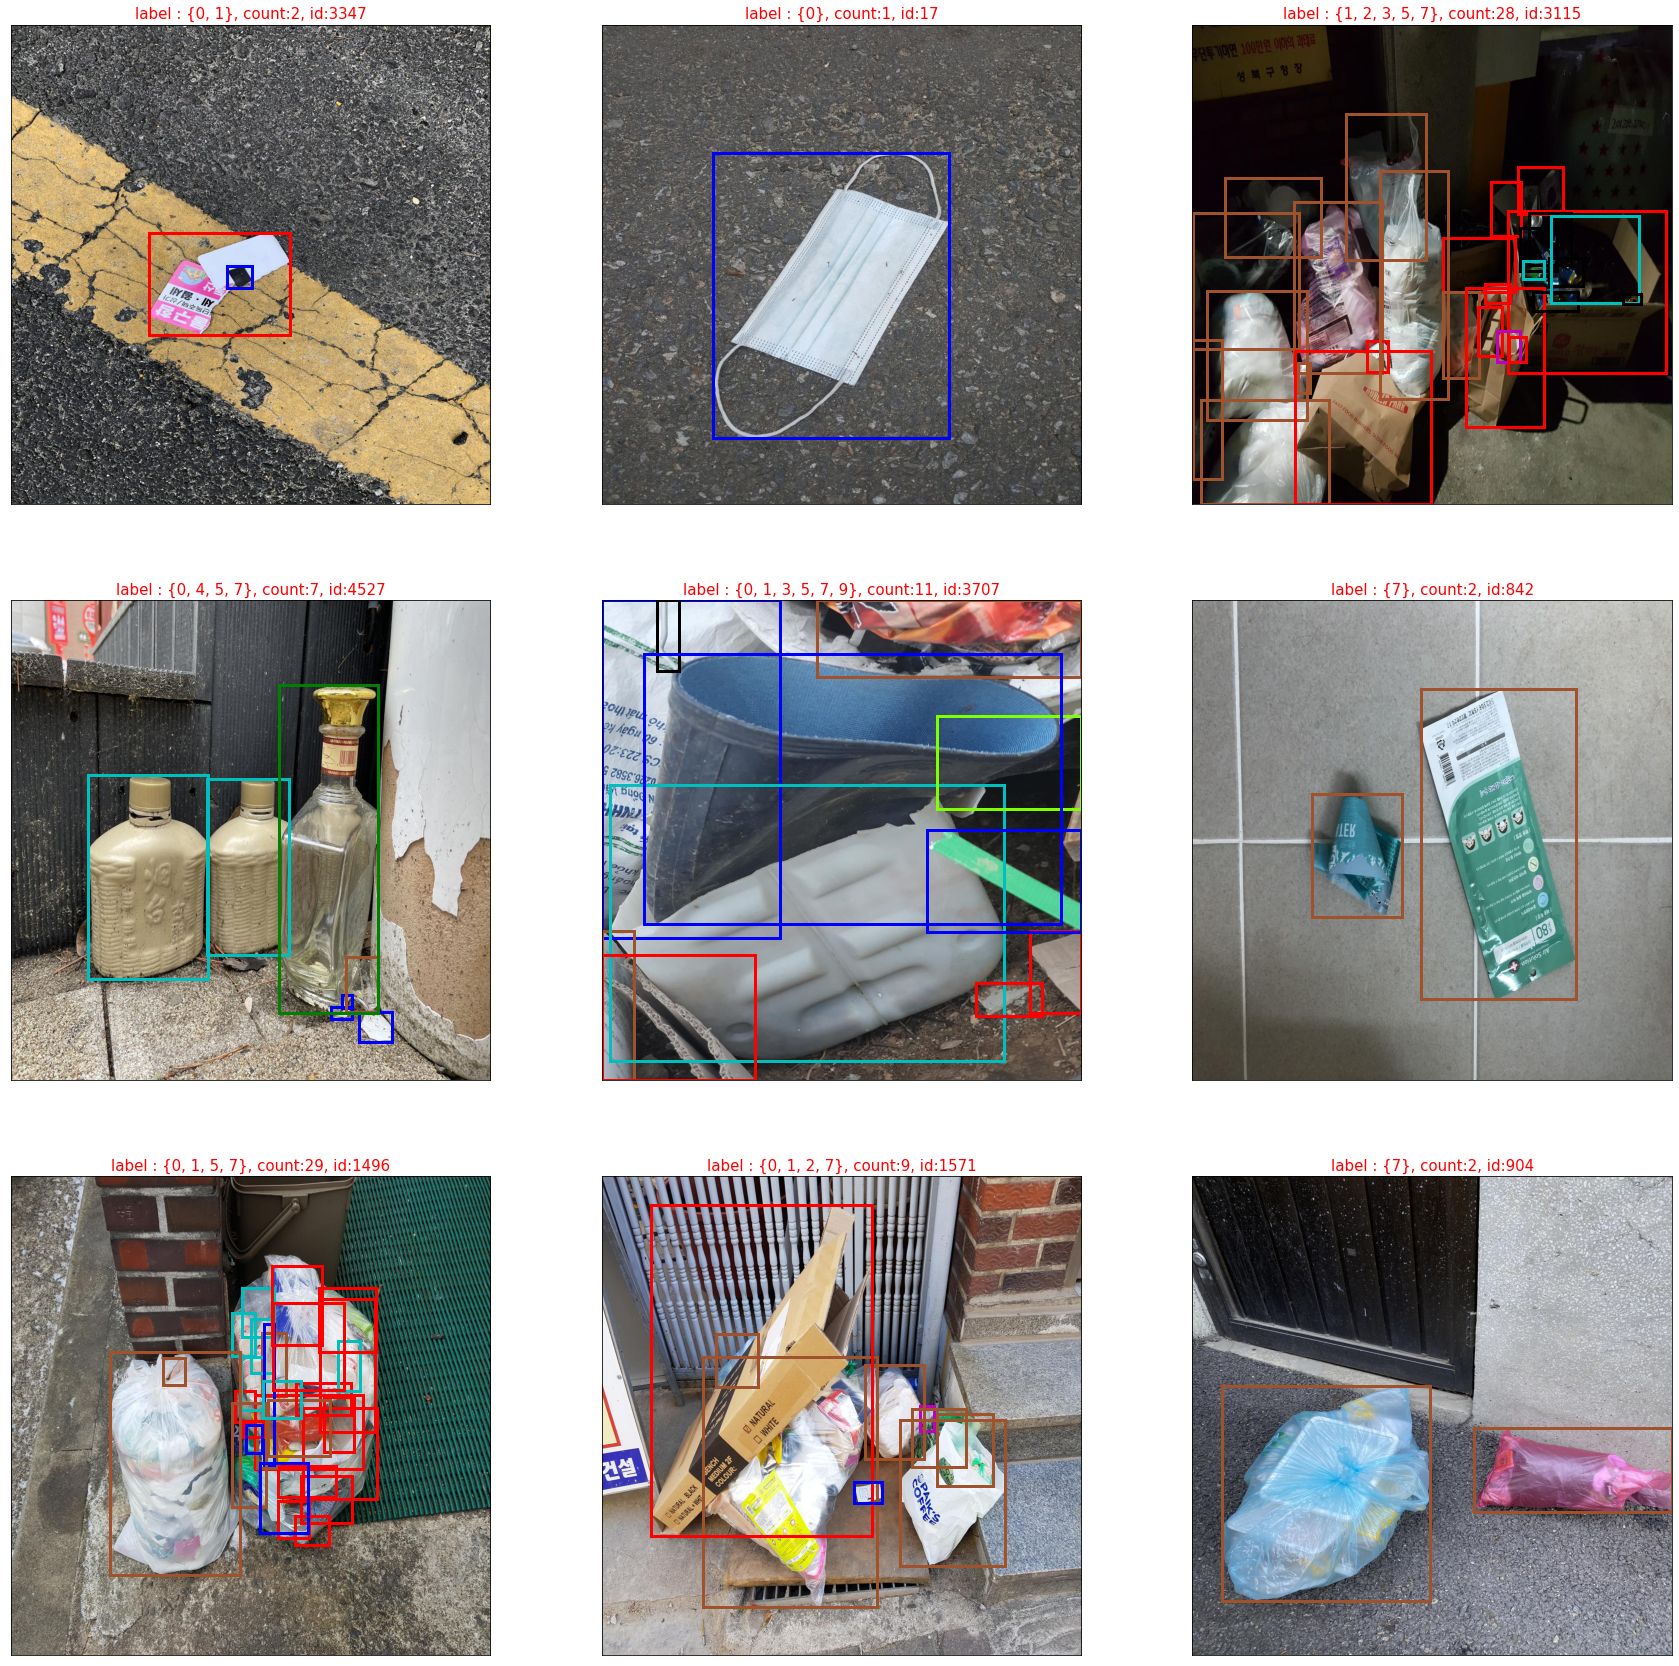

In [15]:
color =  ["b",             "r",     "m",          "k",     "g",     "c",       "y",         "sienna",      "orange",  "chartreuse"]
# label= ['General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']
plt.figure(figsize=(30, 30))
plt.rcParams['axes.titlesize'] = 15
plt.axis('off')
n_x, n_y = 3, 3

for i, index in enumerate([random.randint(0,len(dataset)) for _ in range(n_x*n_y)]):
    plt.subplot(n_x, n_y,i+1)
    image, bboxs, label = dataset[index]
    img = plt.imshow(image); img.axes.get_xaxis().set_visible(False); img.axes.get_yaxis().set_visible(False)
    plt.gca().set_title(f"label : {set(label.tolist())}, count:{len(bboxs)}, id:{index}", color='r')
    if bboxs == None: pass
    else:
        for x, bbox in enumerate(bboxs):
            min_x, min_y, max_x, max_y = bbox
            plt.gca().add_patch(Rectangle((min_x, min_y), max_x-min_x, max_y-min_y, edgecolor=color[label[x]], facecolor='none', linewidth=3))

이미지들의 크기와 RGB 평균 및 표준편차

In [16]:
from tqdm.notebook import tqdm
import os
data_path = "/opt/ml/detection/dataset/"

def get_img_stats(data_set):
    """
    데이터셋에 있는 이미지들의 크기와 RGB 평균 및 표준편차를 수집하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_ids: 학습 데이터셋 하위폴더 이름들

    Returns:
        img_info: 이미지들의 정보 (크기, 평균, 표준편차)
    """
    img_info = dict(heights=[], widths=[], means=[], stds=[])
    for index in tqdm(range(len(data_set))):
        img, bboxs, label = dataset[index]
        _id = data_set.ids[index]
        img = data_set.coco.loadImgs(_id)[0]['file_name']
        img = np.array(Image.open(os.path.join(data_path, img)))
        h, w, _ = img.shape
        img_info['heights'].append(h)
        img_info['widths'].append(w)
        img_info['means'].append(img.mean(axis=(0,1)))
        img_info['stds'].append(img.std(axis=(0,1)))
    return img_info

In [17]:
# info = get_img_stats(dataset)

  0%|          | 0/4883 [00:00<?, ?it/s]

In [19]:
print(f'RGB Mean: {np.mean(info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(info["stds"], axis=0).}')

RGB Mean: [123.6506697  117.39730243 110.07542563]
RGB Standard Deviation: [54.03457934 53.36968771 54.78390763]


In [ ]:
# box, 